In [1]:
import numpy as np
import h5py
import os
import pandas as pd

In [2]:
%pylab inline
import matplotlib.pyplot as plt
import seaborn
seaborn.set()

Populating the interactive namespace from numpy and matplotlib


In [3]:
resultsdir = '../results/cartpole_ddpg_stable'

In [4]:
sorted(os.listdir(resultsdir))

['normal',
 'normal_lrq10',
 'normal_lrq10_no_beta',
 'normal_lrq20',
 'prioritized_v2_no_batchnorm_unstable']

In [5]:
savedirs = {k: os.path.join(resultsdir,k) for k in os.listdir(resultsdir)}

In [6]:
def loadHDF5(filepath):
    output = {}
    with h5py.File(filepath,'r') as f:
        for k in f:
            output[k] = np.array(f[k])
    return output

In [7]:
results = {}
for sd in sorted(savedirs):
    results[sd] = {}
    data = []
    for rd in os.listdir(savedirs[sd]):
        filepath = os.path.join(savedirs[sd],rd,'log.h5')
        
        if os.path.exists(filepath):
            data.append(loadHDF5(filepath))
        else:
            print('path does not exist',filepath)

    if len(data) > 0:
        keys = data[0].keys()
        for k in keys:
            V = [v[k] for v in data]
            if len(V[0].shape) == 1:
                results[sd][k] = np.stack(V)
            else:
                results[sd][k] = np.concatenate(V,axis=-1).T
            print(sd,k,results[sd][k].shape)
    if len(results[sd]) == 0:
        results.pop(sd)

normal Q (10, 9900)
normal action_history (100, 10000)
normal beta (10, 0)
normal duration_cumulative (10, 10000)
normal max_importance_weight (10, 0)
normal reward_history (100, 10000)
normal step_duration_sec (10, 10000)
normal test_ep_returns (100, 99)
normal test_ep_steps (10, 99)
normal_lrq10 Q (10, 9900)
normal_lrq10 action_history (100, 10000)
normal_lrq10 beta (10, 0)
normal_lrq10 duration_cumulative (10, 10000)
normal_lrq10 max_importance_weight (10, 0)
normal_lrq10 reward_history (100, 10000)
normal_lrq10 step_duration_sec (10, 10000)
normal_lrq10 test_ep_returns (100, 99)
normal_lrq10 test_ep_steps (10, 99)
path does not exist ../results/cartpole_ddpg_stable/normal_lrq10_no_beta/experiment-6464792748485307924/log.h5
normal_lrq10_no_beta Q (9, 9900)
normal_lrq10_no_beta action_history (90, 10000)
normal_lrq10_no_beta beta (9, 0)
normal_lrq10_no_beta duration_cumulative (9, 10000)
normal_lrq10_no_beta max_importance_weight (9, 0)
normal_lrq10_no_beta reward_history (90, 10000)

In [8]:
for sd in sorted(results):
    print(sd,results[sd]['test_ep_returns'].shape)

normal (100, 99)
normal_lrq10 (100, 99)
normal_lrq10_no_beta (90, 99)
normal_lrq20 (100, 99)
prioritized_v2_no_batchnorm_unstable (100, 99)


In [9]:
def smooth(x,k=10.):
    return np.convolve(x,np.ones(int(k))*1./k)

In [10]:
def plot_percentiles(x,y=None,label=None,smoothing=False):
    if y is None:
        y = x
        x = np.arange(len(y))
    p10 = np.percentile(y,10,axis=1)
    mean = y.mean(axis=1)
    p90 = np.percentile(y,90,axis=1)
    
    if smoothing:
        f = lambda y: smooth(y)
        p10 = f(p10)
        mean = f(mean)
        p90 = f(p90)
        x = np.arange(len(mean))
        
    plt.fill_between(x,p10,p90,alpha=0.25)
    plt.plot(x,mean,label=label)

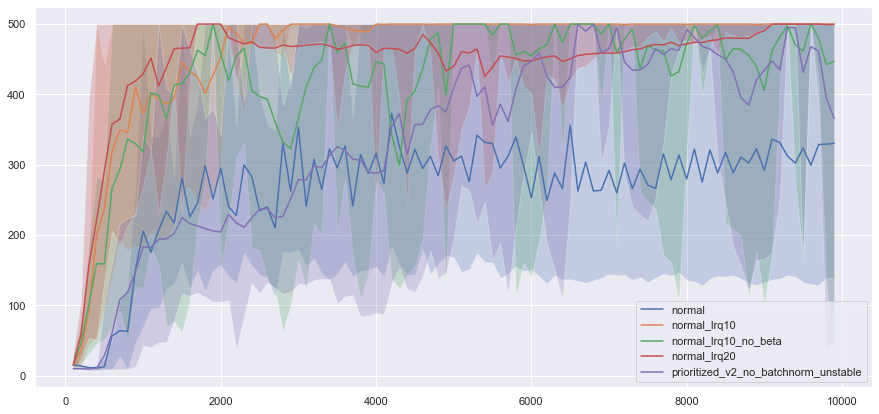

In [11]:
key = 'test_ep_returns'
plt.figure(figsize=(15,7))
for sd in results:
    plot_percentiles(results[sd]['test_ep_steps'][0],results[sd][key].T,label=sd)
_ = plt.legend()

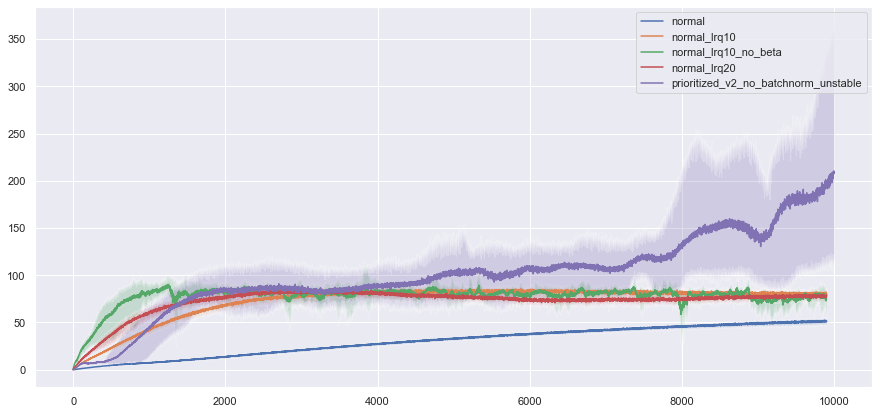

In [12]:
key = 'Q'
plt.figure(figsize=(15,7))
for sd in results:
    plot_percentiles(results[sd][key].T,label=sd)
_ = plt.legend()

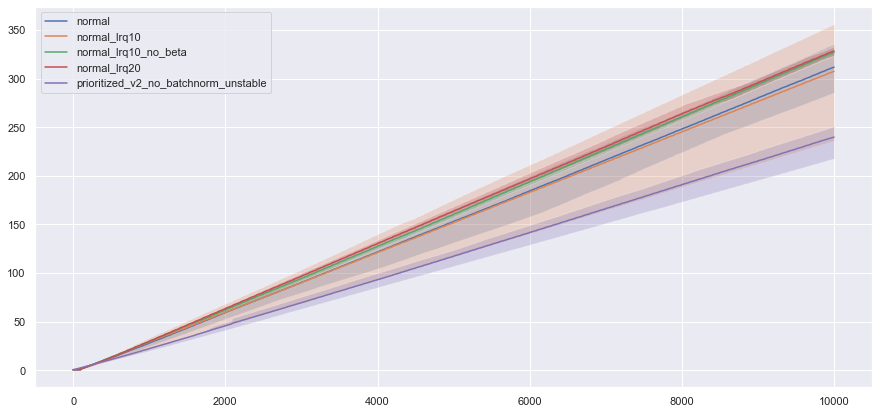

In [13]:
key = 'duration_cumulative'
plt.figure(figsize=(15,7))
for sd in results:
    plot_percentiles(results[sd][key].T,label=sd)
_ = plt.legend()

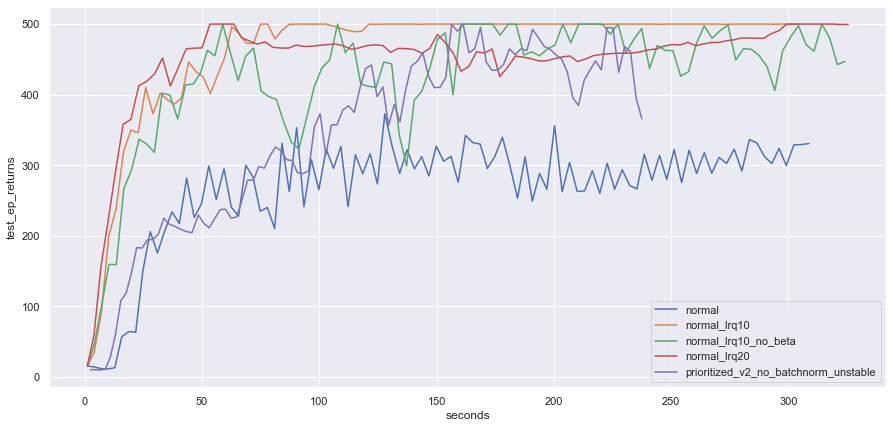

In [14]:
plt.figure(figsize=(15,7))
for sd in results:
    plt.plot(
        results[sd]['duration_cumulative'][:,results[sd]['test_ep_steps'][0]].mean(axis=0),
        results[sd]['test_ep_returns'].mean(axis=0),
        label=sd
    )
plt.xlabel('seconds')
plt.ylabel('test_ep_returns')
_ = plt.legend()